In [79]:
import shapely
from shapely import geometry
from shapely.ops import transform
from shapely.ops import cascaded_union
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from descartes import PolygonPatch
import sys
sys.path.append('../../../alg')
import distance_buffer as db, census_parser as cp, cmclp_solver as solver, data_generator as datagen


from rtree import index

import math
import pyproj
import fiona

import matplotlib.pyplot as plt, pandas as pd, geopandas as gpd, numpy as np

from matplotlib import pyplot
from functools import partial

from matplotlib.patches import Arc
from scipy.stats import truncnorm


In [3]:
reload(cp)

<module 'census_parser' from '../../../alg/census_parser.pyc'>

In [4]:
reload(solver)

<module 'cmclp_solver' from '../../../alg/cmclp_solver.pyc'>

In [5]:
reload(datagen)

<module 'data_generator' from '../../../alg/data_generator.pyc'>

In [ ]:
"""
    
    Parameters
    ----------
     

    Returns
    -------
      
    Note: 
    """

# Helper Methods

In [6]:
def generate_covering_circles(r,coords):
    return [Point(coord).buffer(r) for coord in coords]

In [155]:
def site_indexes_to_coords(results, site_coords):
    """
    Takes the stage result dicts and  gets their coordinate lists
    
    Parameters
    ----------
      results: list[dict['coveringsites']] int
      site_coords: list[(float,float)]

    Returns
    -------
      coords: list[list[(float,float)]]
      
    Note: 
    """
    coords = []
    for i in range(0,len(results)):
        cursites = results[i]['coveringsites']
        if len(cursites) > 0: #clean out empty end stages
            tmpcoords = []
            for ind in cursites:
                tmpcoords.append(site_coords[ind])
            coords.append(tmpcoords)
    return coords


In [11]:
def coalesce_geoms(list_of_geoms):
    one_shape = list_of_geoms[0]
    for i in range(1,len(list_of_geoms)):
        one_shape = one_shape.union(list_of_geoms[i])
    return one_shape
    #return cascaded_union(list_of_geoms)

In [113]:
def calculate_overlap(circles):
    """
    
    Parameters
    ----------
      circles: 

    Returns
    -------
      intersection: 
      
    Note: 
      - src: https://gis.stackexchange.com/questions/237053/getting-intersection-of-multiple-polygons-efficiently-in-python?rq=1
      - USES RTREE PKG
    """
    intersections = []
    idx = index.Index()
    for pos, circle in enumerate(circles):
        idx.insert(pos, circle.bounds)

    for circle in circles:
        merged_circles = cascaded_union([circles[pos] for pos in idx.intersection(circle.bounds) if circles[pos] != circle])
        intersections.append(circle.intersection(merged_circles))

    intersection = cascaded_union(intersections)
    return intersection


In [94]:
def generate_graph_data(mclpdata, cmclpdata, filterstr):
    """
    
    Parameters
    ----------
      mclpdata: list[dict{...}]
      cmclpdata: list[dist{...}]
      filterstr: str

    Returns
    -------
      lines: list[list[]]
      
    Note: 
    """
    lines = []
    tline = []
    for i in range(0,len(mclpdata)):
        tline.append(mclpdata[i][filterstr])
    lines.append(tline)
    tline = []
    for i in range(0,len(cmclpdata)):
        tline.append(cmclpdata[i][filterstr])
    lines.append(tline)
    return lines
        

In [109]:
def plot_data(ax, numstages, data, styles):
    for i in range(0,len(data)):
        ax.plot(list(np.arange(numstages)),data[i][0:numstages], styles[i])

# Plotting Methods

In [99]:
def plot_overlap(ax, numstages, data, styles=['r-','b*','go']):
    """
    Plots overlapping area in ?? meters^2 ?? for each stage
    
    Parameters
    ----------
      ax : matplotlib axis
      numstages : int
      data : list[list[float]]
          List of data to plot for each stage. len(data) == number of lines
      style: list[str]
          
    Returns
    -------
    """
    plot_data(ax,numstages,data,styles)
    

In [100]:
def plot_coverage(ax, numstages, data, styles=['r-','b*','go']):
    """
    Plots ACTUAL and CALC'D pop. coverage for each stage
    
    Parameters
    ----------
      ax : matplotlib axis
      numstages : int
      data : list[list[int]]
          List of data to plot for each stage. len(data) == number of lines
      style: list[str]
          
    Returns
    -------
    """
    plot_data(ax,numstages,data,styles)

        
        

In [41]:
def plot_geoms(geoms):
    fig1, ax1 = plt.subplots(figsize=(10,10))
    for i in range(0,len(geoms)):
        xs, ys = geoms[i].exterior.xy
        ax1.fill(xs, ys, alpha=0.5, fc='r', ec='none')
    pyplot.axis('scaled')
    plt.show() 

# Data Processing Methods

# ____________________________________________________________________


# Experimentation / Debugging Scraps

In [7]:
%store -r pooponmyfacecoords

In [17]:
%store -r place_geom

In [93]:
%store -r ur_mclp_demand_as_sites
%store -r ur_cmclp_demand_as_sites

In [125]:
%store -r tmp_demand_pts

In [175]:
%store -r data

##### Check the overlap each stage for the MCLP soln

In [156]:
#convert indexes to actual coords
mclp_coords = site_indexes_to_coords(ur_mclp_demand_as_sites,tmp_demand_pts)

In [159]:
# generate circles for them
mclp_circles  = []
for l in mclp_coords:
    mclp_circles.append(generate_covering_circles(250.0,l))

In [160]:
mclp_overlap = []
for stage in mclp_circles:
    mclp_overlap.append(calculate_overlap(stage))

In [161]:
for o in mclp_overlap:
    print o.area

349638.824262
1807693.49957
2462987.03388
1291402.48017
2601066.75547
52473.5407093


##### now check the overlap per stage for CMCLP

In [162]:
cmclp_coords = site_indexes_to_coords(ur_cmclp_demand_as_sites, tmp_demand_pts)
cmclp_circles = []
for l in cmclp_coords:
    cmclp_circles.append(generate_covering_circles(250.0,l))
cmclp_overlap = []
for stage in cmclp_circles:
    cmclp_overlap.append(calculate_overlap(stage))
for o in cmclp_overlap:
    print o.area

427318.557607
1642311.40753
1757482.9048
1335195.73898
605247.23618


### Lets compare the overall overlap once all sites have been placed

In [164]:
mclp_all_circles = [item for sublist in mclp_circles for item in sublist]
cmclp_all_circles = [item for sublist in cmclp_circles for item in sublist]

mclp_all_overlap = calculate_overlap(mclp_all_circles)
cmclp_all_overlap = calculate_overlap(cmclp_all_circles)

print mclp_all_overlap.area
print cmclp_all_overlap.area
print (mclp_all_overlap.area - cmclp_all_overlap.area)

28890336.5153
22924676.8265
5965659.68888


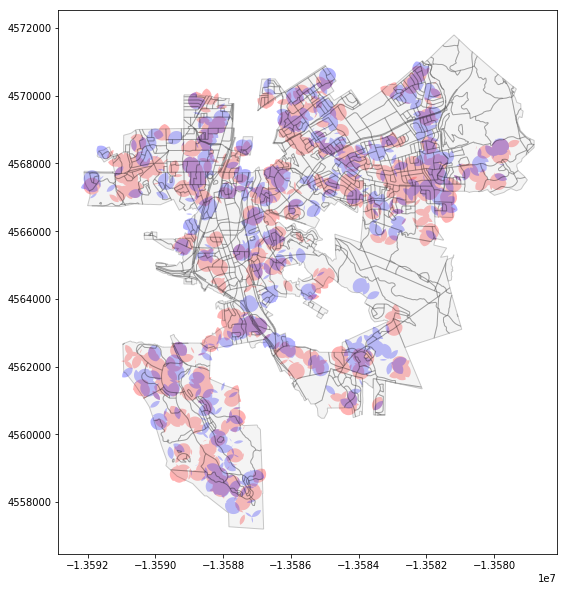

In [167]:
fig2, ax2 = plt.subplots(figsize=(10,10))
for polygon in place_geom:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.2, zorder=3)
    ax2.add_patch(patch)
for i in range(0,len(mclp_all_overlap)):
    xs, ys = mclp_all_overlap[i].exterior.xy
    ax2.fill(xs, ys, alpha=0.3, fc='r', ec='none')
for i in range(0,len(cmclp_all_overlap)):
    xs, ys = cmclp_all_overlap[i].exterior.xy
    ax2.fill(xs, ys, alpha=0.3, fc='b', ec='none')

#ax2.fill(xs, ys, alpha=0.5, fc='b', ec='none')
pyplot.axis('scaled')
plt.show() 

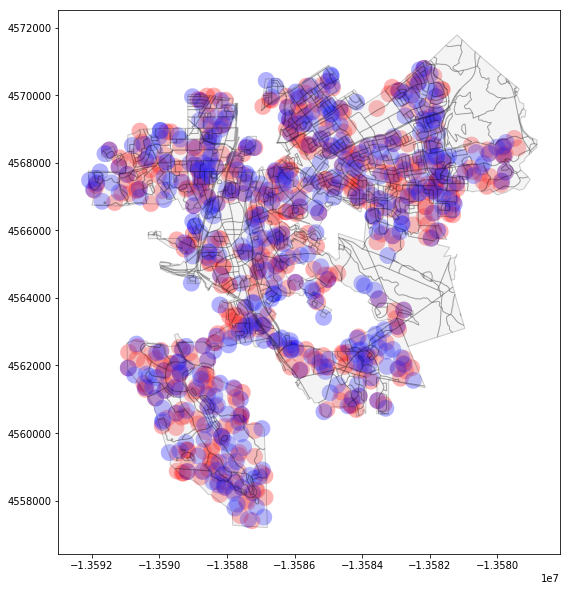

In [174]:
fig3, ax3 = plt.subplots(figsize=(10,10))
for polygon in place_geom:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.2, zorder=3)
    ax3.add_patch(patch)
for i in range(0,len(mclp_circles)):
    for j in range(0,len(mclp_circles[i])):
        xs, ys = mclp_circles[i][j].exterior.xy
        ax3.fill(xs, ys, alpha=0.3, fc='r', ec='none')
for i in range(0,len(cmclp_circles)):
    for j in range(0,len(cmclp_circles[i])):
        xs, ys = cmclp_circles[i][j].exterior.xy
        ax3.fill(xs, ys, alpha=0.3, fc='b', ec='none')

#ax2.fill(xs, ys, alpha=0.5, fc='b', ec='none')
pyplot.axis('scaled')
plt.show() 

In [173]:
len(mclp_circles[0])

100

### compare population coverage at each stage 

In [96]:
linetry1 = generate_graph_data(ur_mclp_demand_as_sites, ur_cmclp_demand_as_sites, "coveredpop")

In [102]:
len(linetry1)

2

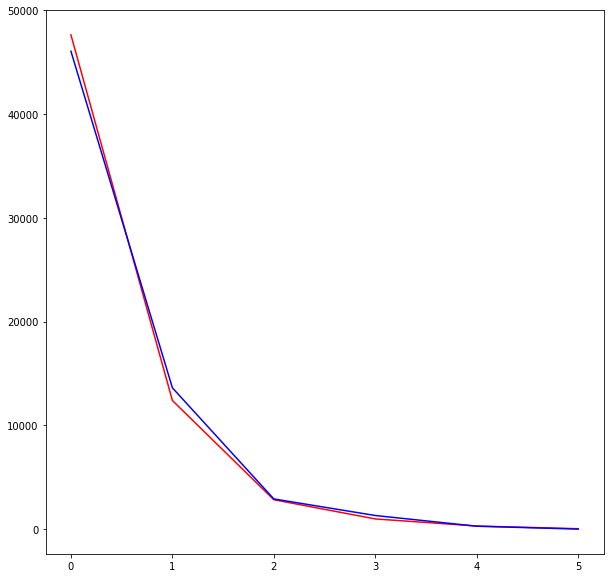

In [183]:
fig4, ax4 = plt.subplots(figsize=(10,10))
plot_coverage(ax4,6, linetry1, ['r-','b-'])


#### compare gaps in coverage

In [181]:
data.keys()

['place_pop_data', 'place_geom']

In [182]:
len(data['place_pop_data'])

987

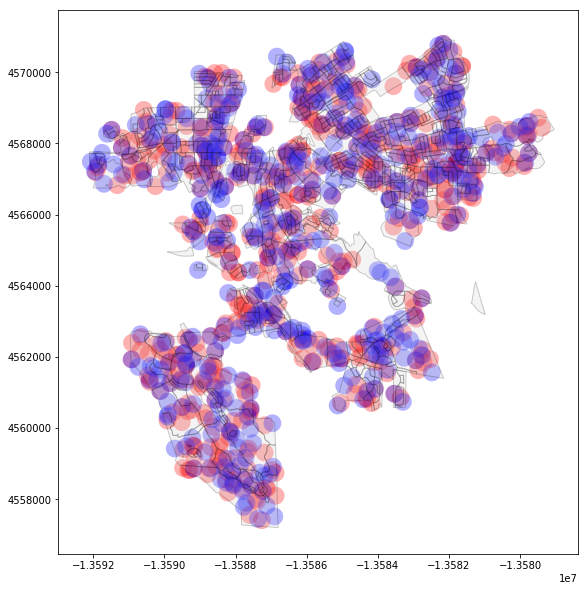

In [191]:
fig5, ax5 = plt.subplots(figsize=(10,10))
pltd = 0
for i in range(0,len(data['place_pop_data'])):
    if data['place_pop_data'][i]['properties']['POP10'] > 0:
        pltd +=1
        patch = PolygonPatch(data['place_geom'][i], fc='#cccccc', ec='k', alpha=0.2, zorder=3)
        ax5.add_patch(patch)
for i in range(0,len(mclp_circles)):
    for j in range(0,len(mclp_circles[i])):
        xs, ys = mclp_circles[i][j].exterior.xy
        ax5.fill(xs, ys, alpha=0.3, fc='r', ec='none')
for i in range(0,len(cmclp_circles)):
    for j in range(0,len(cmclp_circles[i])):
        xs, ys = cmclp_circles[i][j].exterior.xy
        ax5.fill(xs, ys, alpha=0.3, fc='b', ec='none')

pyplot.axis('scaled')
plt.show() 

In [192]:
print pltd

664


In [194]:
populated_geoms = []
for i in range(0,len(data['place_geom'])):
    if data['place_pop_data'][i]['properties']['POP10'] > 0:
        populated_geoms.append(data['place_geom'][i])

In [195]:
mp_populated_geoms = MultiPolygon(populated_geoms)

In [197]:
mclp_circles_coalesced = coalesce_geoms(mclp_all_circles)
cmclp_circles_coalesced = coalesce_geoms(cmclp_all_circles)

In [198]:
mclp_circles_coalesced = MultiPolygon(mclp_circles_coalesced)
cmclp_circles_coalesced = MultiPolygon(cmclp_circles_coalesced)

In [208]:
cmclp_gaps = cmclp_circles_coalesced.symmetric_difference(mp_populated_geoms_buf)
mclp_gaps = mclp_circles_coalesced.symmetric_difference(mp_populated_geoms_buf)

In [209]:
print cmclp_gaps.area
print mclp_gaps.area
print str(mclp_gaps.area - cmclp_gaps.area)

23972903.7807
22738957.3992
-1233946.38151


In [207]:
print cmclp_circles_coalesced.is_valid
print mclp_circles_coalesced.is_valid
mp_populated_geoms_buf = mp_populated_geoms.buffer(0)
print mp_populated_geoms.is_valid
print mp_populated_geoms_buf.is_valid

True
True
False
True


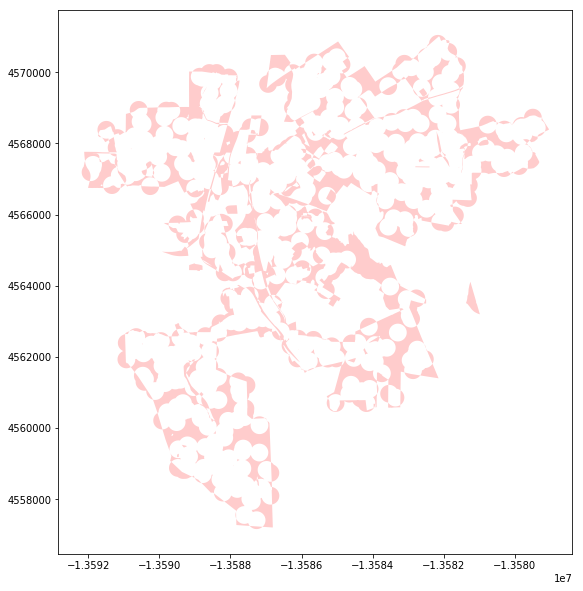

In [211]:
fig6, ax6 = plt.subplots(figsize=(10,10))
pltd = 0
for polygon in mclp_gaps:
    patch = PolygonPatch(polygon, fc='r', ec='none', alpha=0.2, zorder=3)
    ax6.add_patch(patch)
#for polygon in cmclp_gaps:
#    patch = PolygonPatch(polygon, fc='b', ec='none', alpha=0.2, zorder=3)
#    ax6.add_patch(patch)

pyplot.axis('scaled')
plt.show() 